## Latent Diffusion

### Quick Recap on Diffusion Models: 

Diffusion Models have a Forward Process, where small amount of noise is added to an image $\mathbf{x}_0$ over multiple steps. The expression demonstrating this is as follows, 

$$q(\mathbf{x_{1:T}}|\mathbf{x_0}) = \prod_{t=1}^T q(\mathbf{x_{t}}|\mathbf{x_{t-1}})$$

To explain this process simply, say you start off with a picture of an aircraft, $\mathbf{x_0}$ at $\mathbf{t=0}$. In the forward process, noise sampled from a Gaussian Distribution is added to $\mathbf{x_0}$ at $\mathbf{t=1}$ to form $\mathbf{x_1}$. Over large number of iterations of this process, noise accumulates leading to the image turning into an [Isotropic Gaussian Distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic). In order to do this, there is a scheduler, $\beta$ which decides how much noise to add at each step. 

Then in a Backward Process, given as follows, 

$$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T)\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) \quad p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t,t), \mathbf{\Sigma}_\theta(\mathbf{x}_t,t))$$

Where a model is trained to reverse the backward process, i.e, given a noisy image at $\mathbf{t}$, predict the image that occured in step $\mathbf{t-1}$. If the model converges, then we can generate an image starting from random noise, by denoising it step-by-step. 

### Training

To train the model, we take an image, $\mathbf{x}_0$, a random noise sample $\epsilon$, and a time-step $\mathbf{t}$. Using the properties of the forward process, we can compute the result of the $\mathbf{t}^{th}$ iteration straight away using the following equation: 

$$\mathbf{x}_t = \sqrt{\bar\alpha_t} \mathbf{x}_0 + \sqrt{1-\bar\alpha_t} \epsilon \;\;\;\;\;\; \bar\alpha_t = \prod_{i=1}^{i=t} \alpha_i $$

The model, an U-net architecture with t-embedded in certain steps, is then trained such that given a noisy image, $\mathbf{x}_t$ it predicts the noise added to the original high-resolution image, $\epsilon$. This predicted noise is denoted as $\epsilon_0$ and the model is trained using the MSE $||\epsilon - \epsilon_0||_{2}^{2}$ as loss function.

## Why do we need Latent Diffusion Models?

DDPMs are good for small images, but as their sizes are increased the compute needed to train increases exponentially. For example, it took **8 V100 GPUs** over 11 hours to train the DDPM on the CIFAR dataset. This demands something more efficient to train larger resolution images on a single GPU. [Rombach et al](https://github.com/CompVis/latent-diffusion) proposed Latent Diffusion Models where DM's are trained in the latent space of pre-trained auto-encoders instead of the pixel space as used in DDPMs. This helped them increase quality of the images, while reducing training costs. 

Essentially, LDMs first train an autoencoder. The encoder takes an image and makes a latent space representation of it, which the decoder then converts this latent space image back to the image of the original resolution. The entire autoencoer is trained using either L1/L2 loss. 

Then a diffusion model is trained to take noise, and produce latent space representations, which the trained decoder then converts to an image of the original resolution. 

In a VAE, the encoder, given an input image, generates a mean and variance of the encoder distribution of theinput image in the latent space. The decoder then recieves a sample from this distribution and is reponsible for generating the original image. The entire VAE is trained using a combination of reconstruction and KL Divergence loss to ensure that the encoder distributon is as close to the prior normal distribution as possible, for smooth transition in the latent space. 

When a VAE is trained usng L1/L2 loss, the reconstruction image matches the contents of the original image but the quality of the image is lower and blurry, as high frequency information is lost during reconstruction. Even within images, the MSE has a very low value as the only difference is the blur as the contents of the images are otherwise the same. To solve the issue of L2 or MSE not being able to assess the perceptual difference b/w images, a **Perceptual Loss** term had to be added. 

## Perceptual Loss: LPIPS

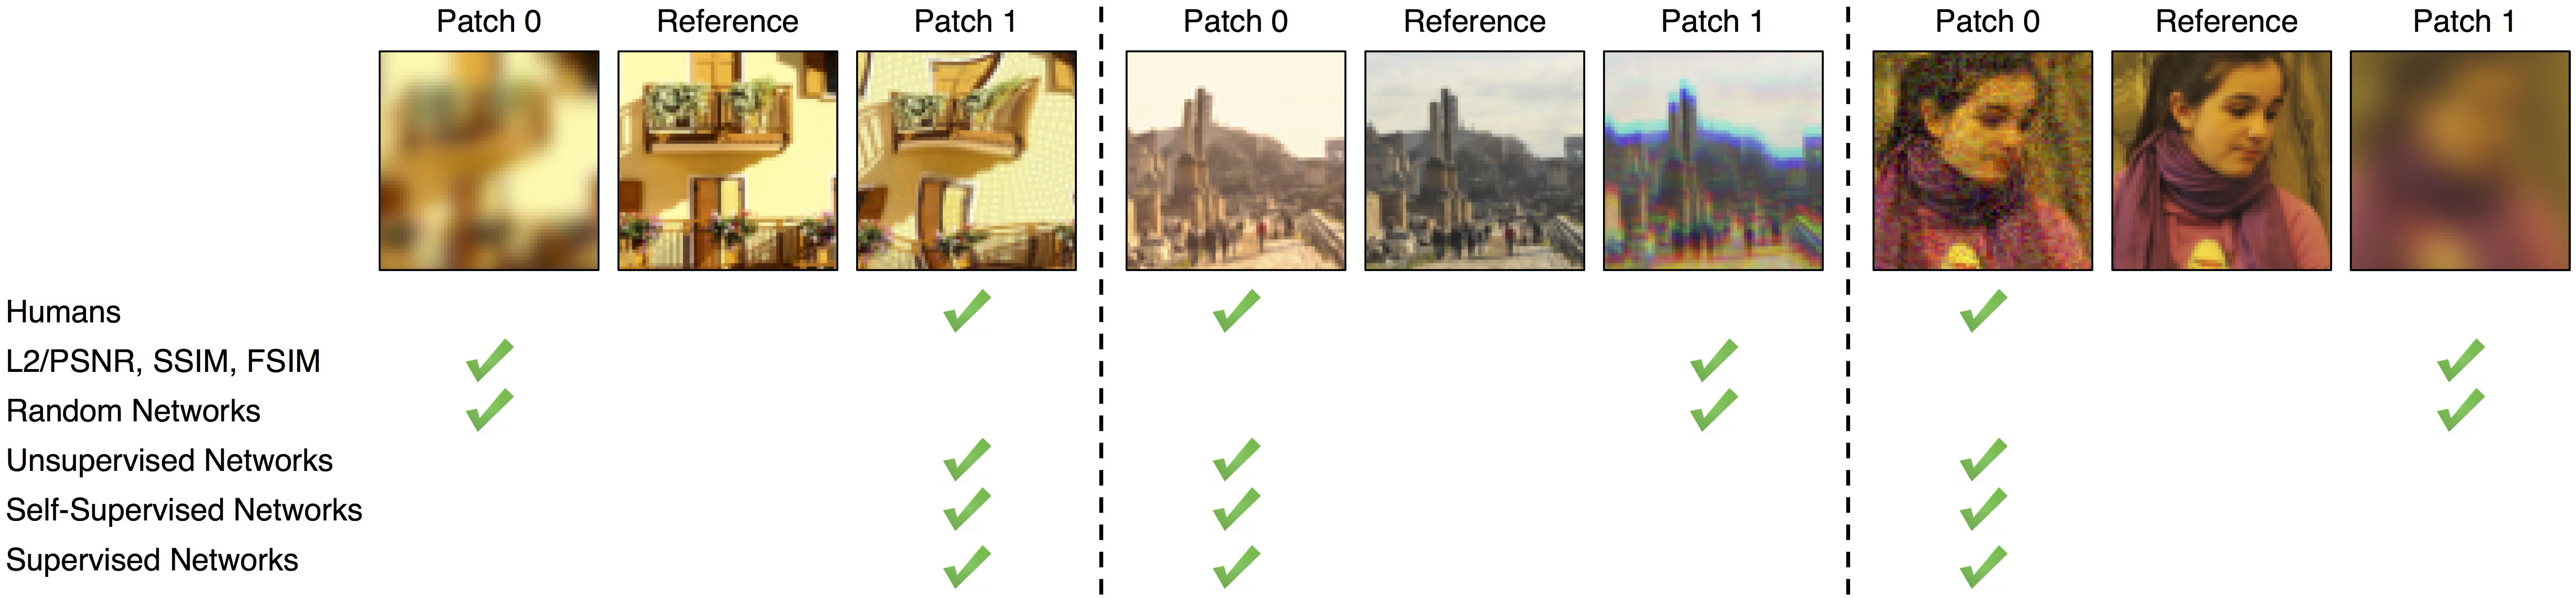

[Zhang et al.](https://github.com/richzhang/PerceptualSimilarity?tab=readme-ov-file#perceptual-similarity-metric-and-dataset-project-page) proposed Learned Perceptual Image Patch Similarity (LPIPS) metric to compute the perceptual difference b/w two images. 

In short, this process uses a VGG-16, or in short a 16 layer conv-net. Both original image, and generated images are passed through the VGG and feature maps are saved at specific layers. Each of these feature maps are then normalised, and then passed through a Convolutional Layer with 1x1 Kernel with 1 output channel, which flattens the features across the channel dimension. Then difference b/w these flattened featuee maps are taken for each feature map pair saved for each layer step. Then the sum of averages of pixel values across height and width of each difference is used as a metric for perceptual depth.

In [4]:
import torch
from torch import nn
import numpy as np
import torch.nn as nn
import torchvision
from collections import namedtuple
import os
import inspect

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class vgg16(nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super().__init__()
        vgg_pretrained_weights = torch.models.vgg16(pretrained=pretrained).features
        # Initialise 5 blocks to access intermediate data 
        self.block1 = nn.Sequential()
        self.block2 = nn.Sequential()
        self.block3 = nn.Sequential()
        self.block4 = nn.Sequential()
        self.block5 = nn.Sequential()

        # Break the for loop into multiple segments to get intermediate data required for LPIPs
        for i in range(4):
            self.block1.add_module(str(i), vgg_pretrained_weights[i])
        for i in range(4, 9): 
            self.block2.add_module(str[i], vgg_pretrained_weights[i])
        for i in range(9, 16):
            self.block3.add_module(str[i], vgg_pretrained_weights[i])
        for i in range(16, 23):
            self.block4.add_module(str[i], vgg_pretrained_weights[i])
        for i in range(23, 30):
            self.block5.add_module(str[i], vgg_pretrained_weights[i])

        # Freeze the model just in case 
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.block1(x)
        hrelu12 = h
        h = self.block2(h)
        hrelu22 = h
        h = self.block3(h)
        hrelu33 = h
        h = self.block4(h)
        hrelu43 = h
        h = self.block5(h)
        hrelu53 = h
        vggout = namedtuple("VGG Outputs", ["relu12, relu22, relu33, relu43, relu53"]) # relyxy means the y-th relu of the x-th layer 
        out = vggout(hrelu12, hrelu22, hrelu33, hrelu43, hrelu53)
        return out
    
class LPIPS(nn.Module):
    def __init__(self, net='vgg', version='0.1', use_dropout=True):
        super().__init__()
        self.version = version
        self.scaling_layer = ScalingLayer() # Normalisation
        self.chns = [64, 128, 256, 512, 512]
        self.L = len(self.chns)
        self.net = vgg16(pretrained=True, requires_grad=False)

        # Each one corresponds to a different level of VGG features
        self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
        self.lins = [self.lin0, self.lin1, self.lin2, self.lin3, self.lin4]
        self.lins = nn.ModuleList(self.lins)

        # Load weights of a trained LPIPS model
        model_path = os.path.abspath(os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth' % (version, net)))
        print('Loading model from: %s' % model_path)
        self.load_state_dict(torch.load(model_path, map_location=device), strict=False)

        # Freeze all parameters
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, img0, img1, normalise=False):
        # Scale the inputs to -1 to +1 range if needed
        if normalise:
            img0 = 2 * img0 - 1
            img1 = 2 * img1 - 1
        
        # Normalize the inputs according to imagenet normalization
        img0_norm, img1_norm = self.scaling_layer(img0), self.scaling_layer(img1)

        # Get VGG outputs 
        img0_vgg, img1_vgg = self.net.forward(img0_norm), self.net.forward(img1_norm)
        feats0, feats1, diffs = {}, {}, {}

        # Compute sq. diff for each layer output

        for i in range(self.L): # self.L is a list of channels; for each layer output
            feats0[i], feats1[i] = torch.functional.normalised(img0_vgg[i], img1_vgg[i])
            diffs[i] = (feats0[i] - feats1[i]) ** 2
        
        # diffs[kk] has the normalised difference of the feature maps of both images 
        # self.lins has the NetLinLayers; self.lins[kk] can be used to access the NetLinLayer with the right number of input channels
        # self.lins[kk](diffs[kk]) converts multiple channel input to single channel output
        # spatial average averages the values of pixels over hxw and outputs a single number 
        # this is done for each feature map
        res = [spatial_average(self.lins[kk](diffs[kk]), keepdim=True) for kk in range(self.L)] 
        
        val = 0
        
        # Aggregate the results of each layer
        for l in range(self.L):
            val += res[l]
        return val



def spatial_average(x, keepdim=True):
    return x.mean([2,3], keepdim=keepdim)

class ScalingLayer(nn.Module):
    def __init__(self):
        super().__init__()
        # Imagnet normalization for (0-1)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])
    
    def forward(self, inp):
        return (inp - self.shift) / self.scale

class NetLinLayer(nn.Module):    
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super().__init__()
        
        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False), ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.model(x)
        return out

## Advasarial Loss 

LDMs consist of three combined loss functions, the L1/L2 Reconstruction Loss that checks for similarity in content of images, Perceptual Loss using LPIPS for similarity in perceptual depth, and Advasarial Loss. 

The auto-encoder can be thought of as a generator, which generates samples for reconstructions. The input image can be thought of as the real image, and the reconstruction as a fake. There is a discriminator which ientifies which is real and which is fake. The generator's goal is to try and fool the discriminator, by making generated samples which can pass off as real. At the same time, the discriminator gets better at classifying real/ fake images or input v/s generated samples. The math bechind this is very similar to the inner workings of GANs. 

Obviously, the discriminator penalises the autoencoder for generating blurry reconstructions. The decoder has to generate higher resolution images from compressed versions, i.e it has to learn to generate high frequency textures which is missing in the latent image. The discriminator ensures it is learning the right things.

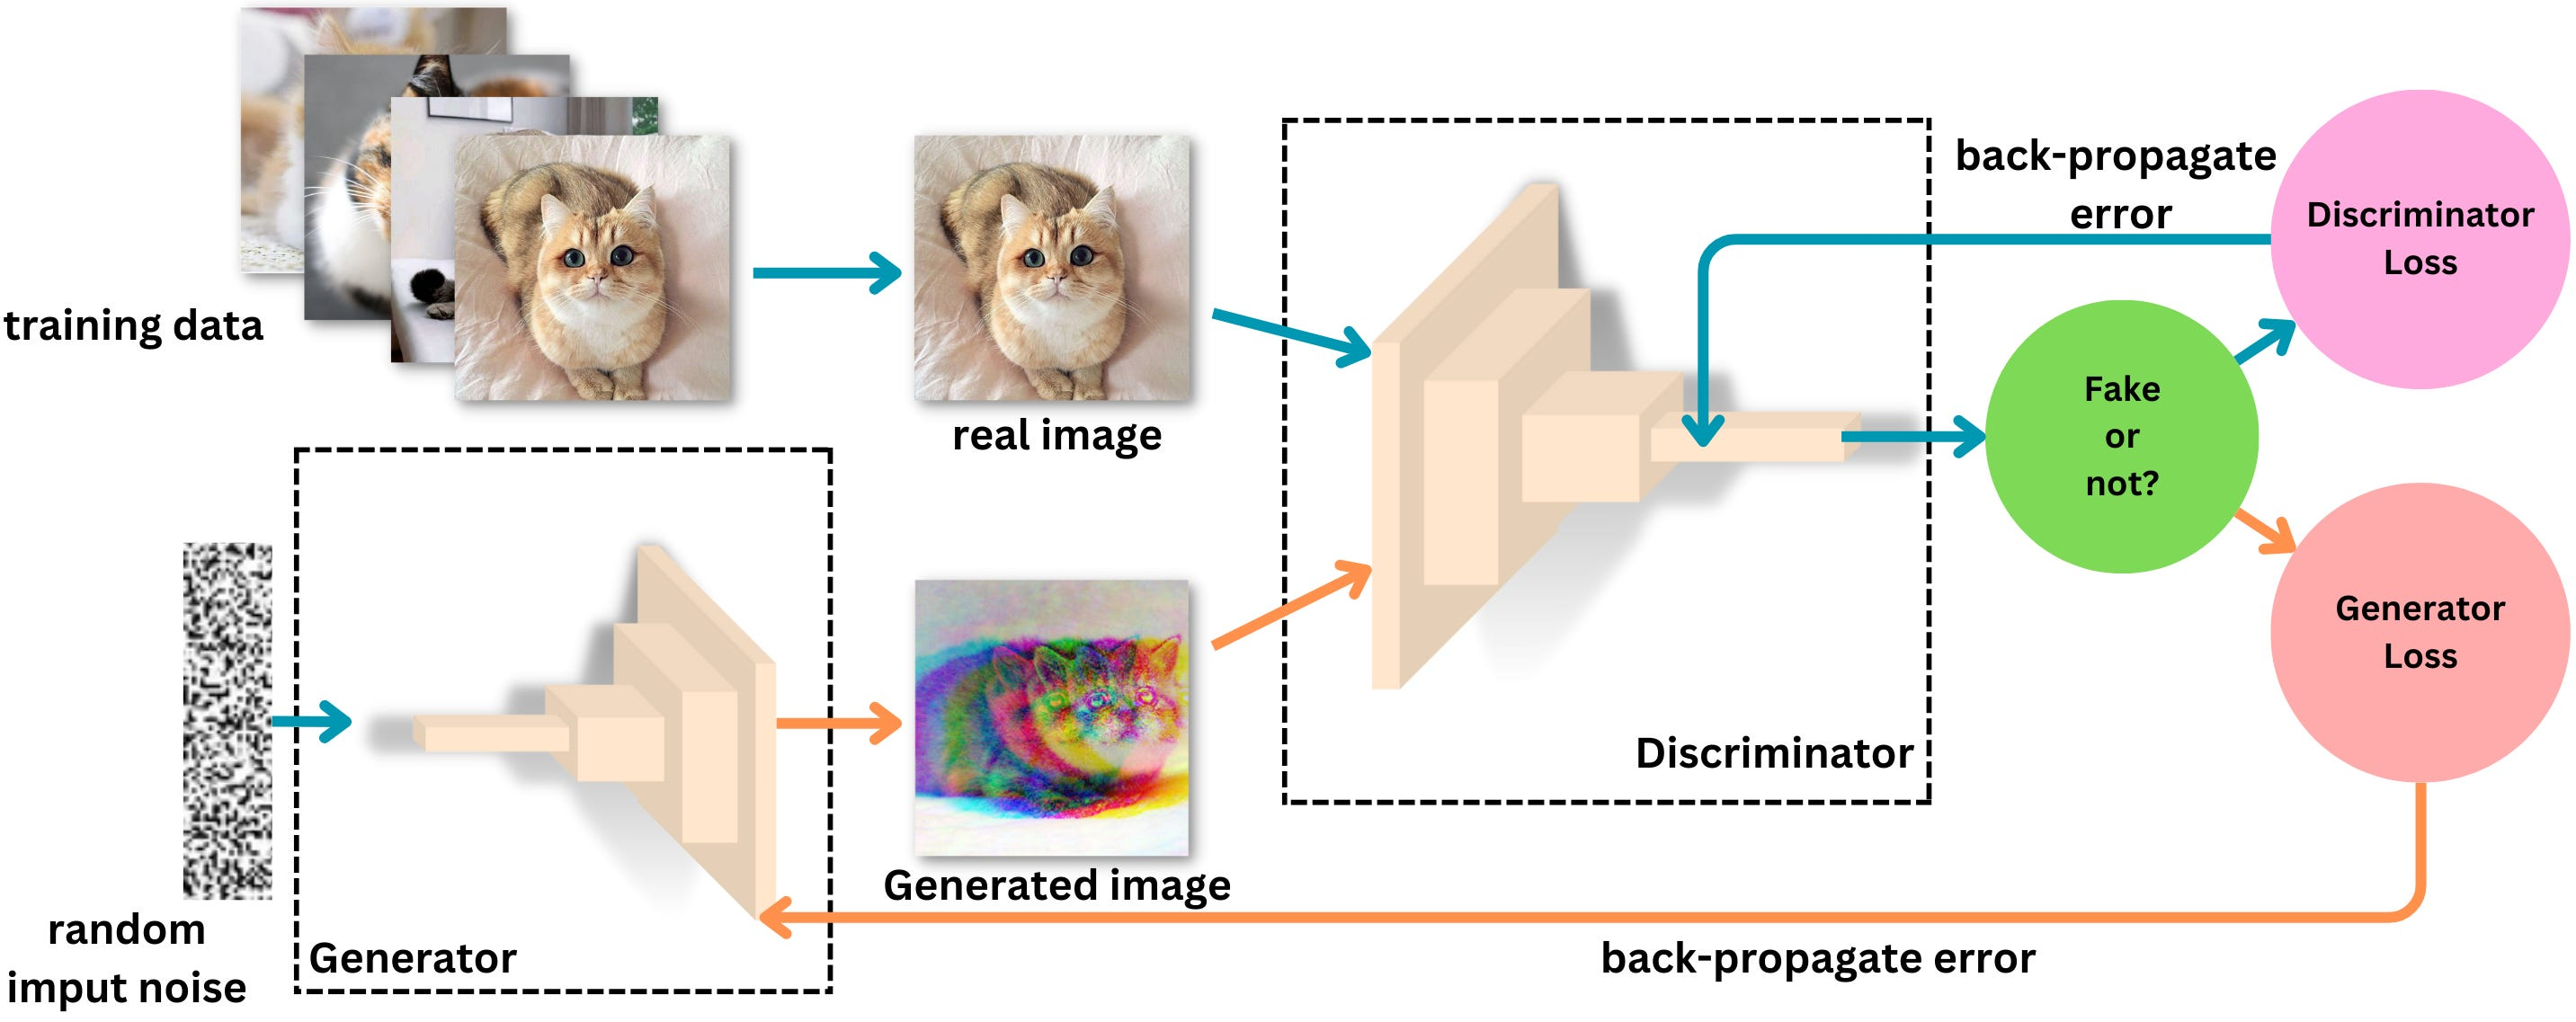

## Auto Encoder Architecture 

